### In this notebook we will use Facebook's prophet package to forecast hourly Dry Bulb Temperatures.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

The data we will be using is hourly dry bulb temperatures data from New Orleans airport. 

Pulling the data which has data from 2010-2019.

In [2]:
pjme = pd.read_csv('New_Orleans_update.csv',
                   index_col=[1], parse_dates=[0]) # We set the index column and know it has dates

C:\Users\Jimsyd\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (30,31,41,42,46,49,51) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
pjme = pjme[['HourlyDryBulbTemperature']]

In [4]:
#pjme['HourlyDryBulbTemperature'] =pjme['HourlyDryBulbTemperature'].str.replace('s', '')
pjme['HourlyDryBulbTemperature'] = pjme['HourlyDryBulbTemperature'].astype(float)

In [5]:
pjme = pjme.loc[pjme['HourlyDryBulbTemperature'] > 1]

In [6]:
pjme

,HourlyDryBulbTemperature
DATE,
2010-01-01 00:00:00,54.0
2010-01-01 00:53:00,52.0
2010-01-01 01:53:00,51.0
2010-01-01 02:53:00,50.0
2010-01-01 03:32:00,50.0
...,...
2019-12-31 20:53:00,51.0
2019-12-31 21:53:00,48.0
2019-12-31 22:53:00,49.0


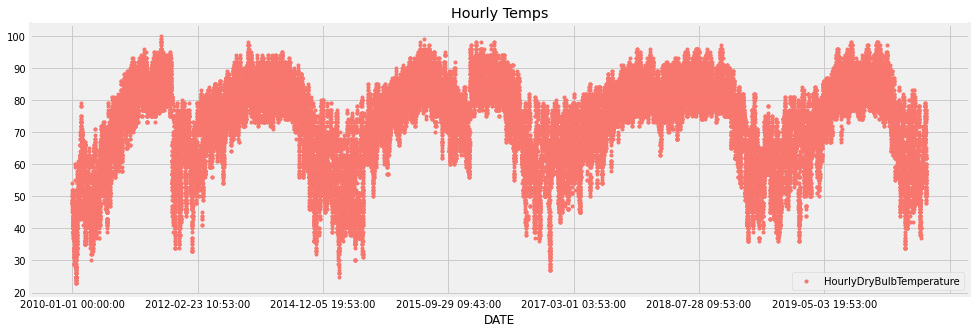

In [7]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='Hourly Temps')
plt.show()

## EDA

We will create some time series features to see how the trends are impacted by day of week, hour and time of year.

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].apply(pd.to_datetime).dt.hour
    df['dayofweek'] = df['date'].apply(pd.to_datetime).dt.dayofweek
    df['quarter'] = df['date'].apply(pd.to_datetime).dt.quarter
    df['month'] = df['date'].apply(pd.to_datetime).dt.month
    df['year'] = df['date'].apply(pd.to_datetime).dt.year
    df['dayofyear'] = df['date'].apply(pd.to_datetime).dt.dayofyear
    df['dayofmonth'] = df['date'].apply(pd.to_datetime).dt.day
    df['weekofyear'] = df['date'].apply(pd.to_datetime).dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='HourlyDryBulbTemperature')

features_and_target = pd.concat([X, y], axis=1)

In [9]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,HourlyDryBulbTemperature
DATE,,,,,,,,,
2010-01-01 00:00:00,0,4,1,1,2010,1,1,53,54.0
2010-01-01 00:53:00,0,4,1,1,2010,1,1,53,52.0
2010-01-01 01:53:00,1,4,1,1,2010,1,1,53,51.0
2010-01-01 02:53:00,2,4,1,1,2010,1,1,53,50.0
2010-01-01 03:32:00,3,4,1,1,2010,1,1,53,50.0


## Plotting the features to see trends

Daily average temps have strong daily and seasonal properties.

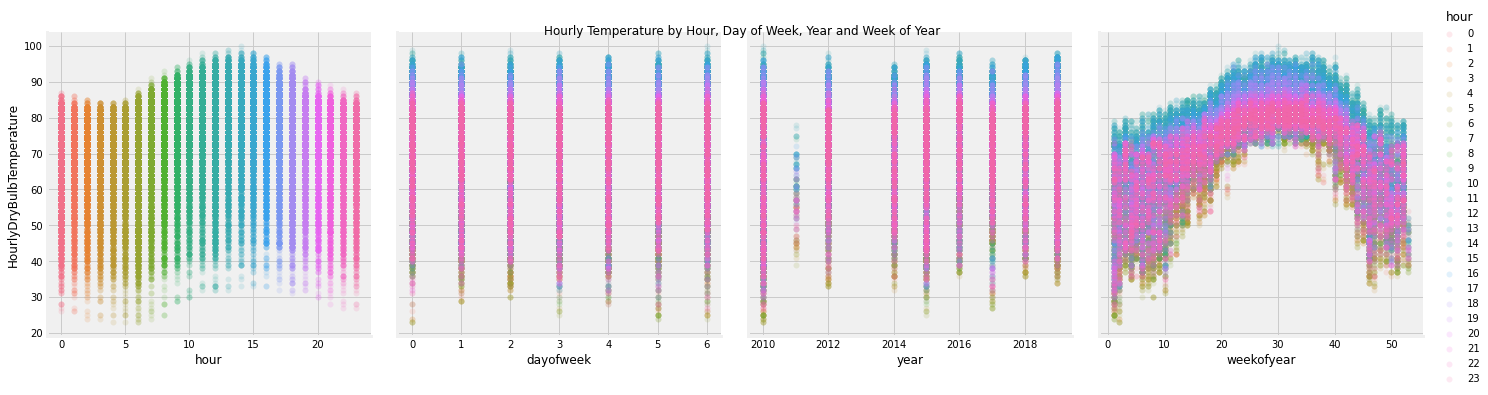

In [10]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='HourlyDryBulbTemperature',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Hourly Temperature by Hour, Day of Week, Year and Week of Year')
plt.show()

### Train/Test Split

We'll cut off the data near the end of 2015 to use as our validation set. We will train on earlier data.

In [11]:
split_date = '2015-12-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

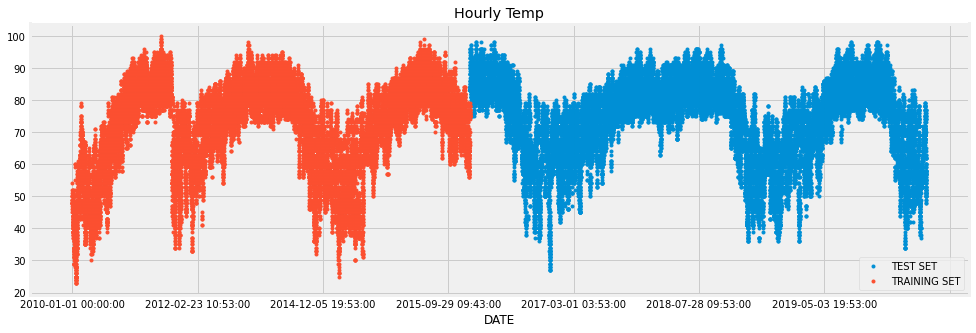

In [12]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'HourlyDryBulbTemperature': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'HourlyDryBulbTemperature': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Hourly Temp', style='.')
plt.show()

## Simple Prophet Model

Prophet model expects the dataset to be name3d a specifi way so we will rename our datafram columns before feeding it into the model.

In [13]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'DATE':'ds',
                     'HourlyDryBulbTemperature':'y'}).head()

,ds,y
0,2010-01-01 00:00:00,54.0
1,2010-01-01 00:53:00,52.0
2,2010-01-01 01:53:00,51.0
3,2010-01-01 02:53:00,50.0
4,2010-01-01 03:32:00,50.0


In [14]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_test.reset_index() \
              .rename(columns={'DATE':'ds',
                               'HourlyDryBulbTemperature':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [15]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'DATE':'ds'}))

In [16]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-04 18:00:00,72.891537,78.594101,94.848481,72.891537,72.891537,13.740102,13.740102,13.740102,1.721913,...,0.040397,0.040397,0.040397,11.977793,11.977793,11.977793,0.0,0.0,0.0,86.631639
1,2016-07-04 18:53:00,72.892047,77.578149,93.966508,72.892047,72.892047,12.710084,12.710084,12.710084,0.680911,...,0.050430,0.050430,0.050430,11.978743,11.978743,11.978743,0.0,0.0,0.0,85.602130
2,2016-07-04 19:53:00,72.892624,75.842290,92.727337,72.892624,72.892624,11.791236,11.791236,11.791236,-0.248817,...,0.060267,0.060267,0.060267,11.979785,11.979785,11.979785,0.0,0.0,0.0,84.683860
3,2016-07-04 20:53:00,72.893202,76.476903,92.392789,72.893202,72.893202,11.080128,11.080128,11.080128,-0.969182,...,0.068519,0.068519,0.068519,11.980791,11.980791,11.980791,0.0,0.0,0.0,83.973330
4,2016-07-04 21:53:00,72.893779,75.141009,91.120676,72.893779,72.893779,10.431519,10.431519,10.431519,-1.625479,...,0.075237,0.075237,0.075237,11.981761,11.981761,11.981761,0.0,0.0,0.0,83.325298


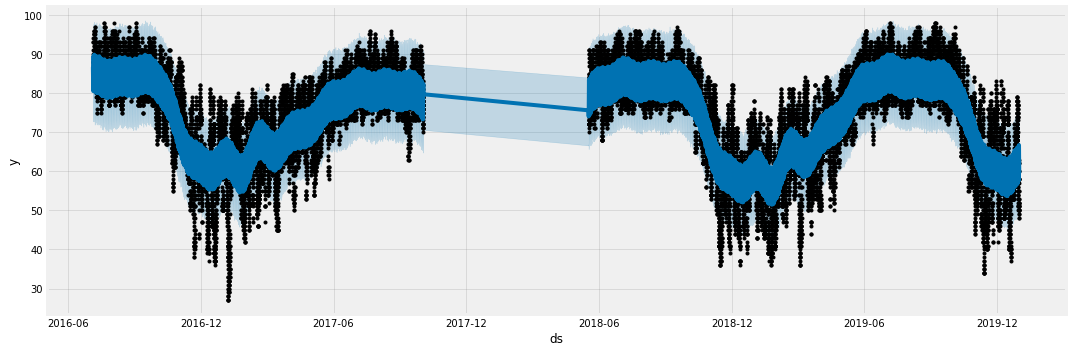

In [17]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

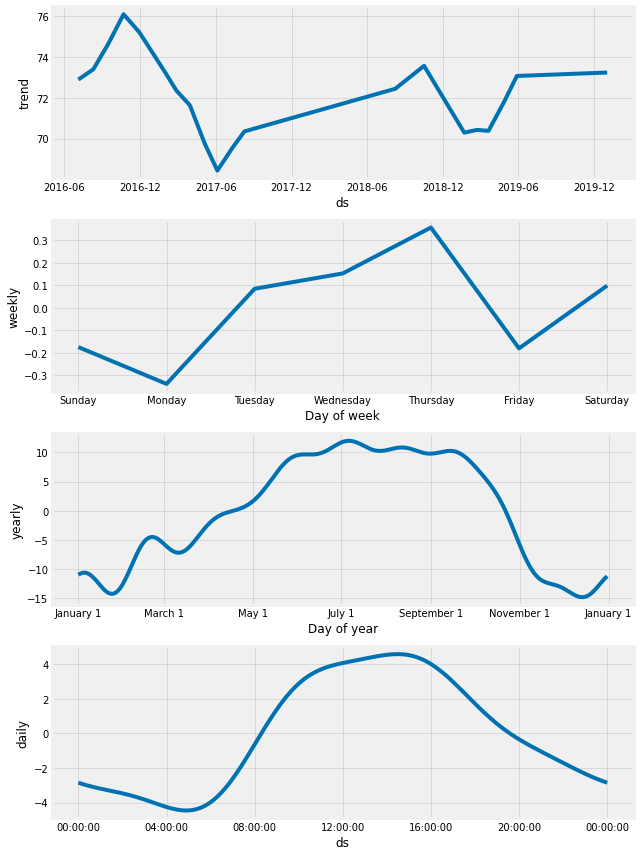

In [18]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

## Error Metrics

In [20]:
mean_squared_error(y_true=pjme_test['HourlyDryBulbTemperature'],
                   y_pred=pjme_test_fcst['yhat'])

40.25932457339378

In [21]:
mean_absolute_error(y_true=pjme_test['HourlyDryBulbTemperature'],
                   y_pred=pjme_test_fcst['yhat'])

4.7814584928929085

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['HourlyDryBulbTemperature'],
                   y_pred=pjme_test_fcst['yhat'])

7.320611767970796